In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [8]:
resnet50features.shape

(301, 2048)

In [9]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

In [11]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = PredefinedSplit(test_fold)
grid_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
grid_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s


[CV] .............. C=0.01, gamma=1e-07, score=0.333333, total=   0.6s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.333333, total=   0.6s
[CV] .............. C=0.01, gamma=1e-08, score=0.737705, total=   0.7s
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.333333, total=   0.7s
[CV] .............. C=0.01, gamma=1e-09, score=0.333333, total=   0.8s
[CV] .............. C=0.01, gamma=1e-07, score=0.333333, total=   0.6s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.333333, total=   0.8s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.4s


[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.333333, total=   0.8s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.333333, total=   1.0s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.333333, total=   0.4s
[CV] ............. C=0.01, gamma=0.0001, score=0.737705, total=   0.5s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.333333, total=   0.5s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.333333, total=   0.5s
[CV] C=0.01, gamma=10.0 ..............................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


[CV] ............. C=0.01, gamma=0.0001, score=0.333333, total=   0.6s
[CV] ............. C=0.01, gamma=0.0001, score=0.333333, total=   0.8s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.333333, total=   0.8s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.333333, total=   0.8s
[CV] C=0.01, gamma=100.0 .............................................
[CV] ................ C=0.01, gamma=1.0, score=0.333333, total=   0.4s
[CV] .............. C=0.01, gamma=0.001, score=0.333333, total=   1.0s
[CV] C=0.01, gamma=100.0 .............................................
[CV] ................ C=0.01, gamma=1.0, score=0.333333, total=   0.4s
[CV] C=0.01, gamma=100.0 .............................................
[CV] ............... C=0.01, gamma=0.01, score=0.333333, total=   0.8s
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.6s


[CV] ................ C=0.01, gamma=1.0, score=0.333333, total=   0.9s
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.655738, total=   1.0s
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.333333, total=   1.0s
[CV] .............. C=0.01, gamma=0.001, score=0.737705, total=   1.1s
[CV] ................ C=0.01, gamma=0.1, score=0.333333, total=   0.9s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.754098, total=   1.0s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.333333, total=   1.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.2s


[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.333333, total=   0.5s
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.333333, total=   1.0s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.333333, total=   0.6s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.333333, total=   1.0s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.737705, total=   0.4s
[CV] .............. C=0.01, gamma=100.0, score=0.333333, total=   0.9s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] C

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    4.1s


[CV] ............. C=0.01, gamma=1000.0, score=0.333333, total=   1.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.333333, total=   0.9s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.737705, total=   0.9s
[CV] ............... C=0.1, gamma=1e-08, score=0.333333, total=   1.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.333333, total=   1.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.333333, total=   0.8s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.333333, total=   0.9s
[CV] ............... C=0.1, gamma=1e-06, score=0.333333, total=   0.4s
[CV] C

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    4.8s


[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.333333, total=   1.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.333333, total=   1.2s
[CV] ............... C=0.1, gamma=1e-06, score=0.333333, total=   1.1s
[CV] C=0.1, gamma=1.0 ................................................
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................ C=0.1, gamma=0.01, score=0.333333, total=   0.4s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.333333, total=   0.9s
[CV] .............. C=0.1, gamma=0.0001, score=0.333333, total=   0.6s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ................ C=0.1, gamma=0.01, score=0.333333, total=   0.4s
[CV] C=0.1, gamma=1.0 ................................................
[CV] C

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.7s


[CV] ............... C=0.1, gamma=0.001, score=0.516667, total=   0.9s
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ............... C=0.1, gamma=0.001, score=0.500000, total=   1.1s
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ............... C=0.1, gamma=0.001, score=0.433333, total=   0.9s
[CV] ................ C=0.1, gamma=0.01, score=0.333333, total=   0.9s
[CV] C=0.1, gamma=1000.0 .............................................
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.754098, total=   0.4s
[CV] ................. C=0.1, gamma=0.1, score=0.409836, total=   0.6s
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................. C=0.1, gamma=1.0, score=0.333333, total=   0.4s
[CV] C=1.0, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.6s


[CV] ................. C=0.1, gamma=1.0, score=0.333333, total=   1.0s
[CV] .............. C=0.1, gamma=1000.0, score=0.333333, total=   0.4s
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.704918, total=   0.4s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.333333, total=   1.1s
[CV] ............... C=0.1, gamma=100.0, score=0.327869, total=   0.8s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    7.6s


[CV] C=1.0, gamma=0.001 ..............................................
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.333333, total=   0.9s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.737705, total=   0.4s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.333333, total=   0.9s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.333333, total=   0.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.333333, total=   0.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.333333, total=   0.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.6s


[CV] ............... C=1.0, gamma=0.001, score=0.883333, total=   0.6s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.883333, total=   0.6s
[CV] ................ C=1.0, gamma=0.01, score=0.866667, total=   0.4s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] C=1.0, gamma=100.0 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.733333, total=   0.9s
[CV] C=1.0, gamma=100.0 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.733333, total=   1.0s
[CV] C=1.0, gamma=100.0 ..............................................
[CV] ............... C=1.0, gamma=0.001, score=0.883333, total=   0.7s
[CV] C=1.0, gamma=100.0 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.666667, total=   0.8s
[CV] C=1.0, gamma=100.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.7s


[CV] ................ C=1.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.327869, total=   0.9s
[CV] ................. C=1.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] .............. C=1.0, gamma=1000.0, score=0.327869, total=   0.5s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] C=10.0, gamma=1e-08 .............................................
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] ................. C=1.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.333333, total=   0.6s
[CV] ................ C=1.0, gamma=10.0, score=0.333333, total=   0.9s
[CV] C

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   10.6s


[CV] .............. C=10.0, gamma=1e-07, score=0.333333, total=   0.5s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.333333, total=   1.0s
[CV] .............. C=10.0, gamma=1e-09, score=0.333333, total=   0.8s
[CV] C=10.0, gamma=0.001 .............................................
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.737705, total=   0.5s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.333333, total=   0.8s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.754098, total=   0.5s
[CV] .............. C=10.0, gamma=1e-08, score=0.333333, total=   0.9s
[CV] ............. C=10.0, gamma=0.0001, score=0.836066, total=   0.3s
[CV] C=10.0, gamma=0.001 .............................................
[CV] C

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   11.5s


[CV] .............. C=10.0, gamma=1e-05, score=0.733333, total=   0.8s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.333333, total=   0.8s
[CV] .............. C=10.0, gamma=1e-05, score=0.716667, total=   0.8s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] C=10.0, gamma=100.0 .............................................
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.934426, total=   0.4s
[CV] C=10.0, gamma=100.0 .............................................
[CV] .............. C=10.0, gamma=0.001, score=0.900000, total=   0.4s
[CV] C=10.0, gamma=100.0 .............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.783333, total=   0.8s
[CV] C=10.0, gamma=100.0 .............................................
[CV] ............... C=10.0, gamma=0.01, score=0.883333, total=   0.5s
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   12.7s


[CV] ............. C=10.0, gamma=1000.0, score=0.333333, total=   0.4s
[CV] ................ C=10.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] ............... C=10.0, gamma=10.0, score=0.327869, total=   0.8s
[CV] C=100.0, gamma=1e-07 ............................................
[CV] C=100.0, gamma=1e-07 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=100.0, gamma=1e-07 ............................................
[CV] ............. C=10.0, gamma=1000.0, score=0.327869, total=   0.5s
[CV] .............. C=10.0, gamma=100.0, score=0.333333, total=   0.8s
[CV] C=100.0, gamma=1e-06 ............................................
[CV] C=100.0, gamma=1e-07 ............................................
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] ............. C=10.0, gamma=1000.0, score=0.333333, total=   0.5s
[CV] C

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   13.7s


[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.800000, total=   0.5s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.333333, total=   0.8s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.333333, total=   0.8s
[CV] ............. C=100.0, gamma=1e-08, score=0.333333, total=   0.8s
[CV] ............ C=100.0, gamma=0.0001, score=0.933333, total=   0.2s
[CV] C=100.0, gamma=0.01 .............................................
[CV] C=100.0, gamma=0.01 .............................................
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.934426, total=   0.2s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.833333, total=   0.3s
[CV] C

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   14.3s


[CV] .............. C=100.0, gamma=0.01, score=0.883333, total=   0.4s
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.850000, total=   0.5s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.333333, total=   0.5s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.333333, total=   0.5s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.333333, total=   0.7s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.333333, total=   0.5s
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .............. C=100.0, gamma=0.01, score=0.783333, total=   0.8s
[CV] ............... C=100.0, gamma=0.1, score=0.333333, total=   0.5s
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   15.7s


[CV] ............ C=100.0, gamma=1000.0, score=0.333333, total=   0.5s
[CV] ............. C=100.0, gamma=100.0, score=0.333333, total=   0.9s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.333333, total=   0.4s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.333333, total=   0.5s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.333333, total=   0.5s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.333333, total=   0.7s
[CV] ............ C=1000.0, gamma=1e-09, score=0.704918, total=   0.7s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.833333, total=   0.4s
[CV] C

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   16.7s


[CV] ............ C=1000.0, gamma=1e-07, score=0.683333, total=   0.8s
[CV] ............ C=1000.0, gamma=1e-07, score=0.800000, total=   0.8s
[CV] C=1000.0, gamma=10.0 ............................................
[CV] C=1000.0, gamma=10.0 ............................................
[CV] C=1000.0, gamma=10.0 ............................................
[CV] C=1000.0, gamma=10.0 ............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.950000, total=   0.3s
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.900000, total=   0.4s
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............ C=1000.0, gamma=0.001, score=0.900000, total=   0.4s
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............ C=1000.0, gamma=0.001, score=0.916667, total=   0.4s
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   18.0s


[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.333333, total=   0.9s
[CV] ............ C=1000.0, gamma=100.0, score=0.333333, total=   0.5s
[CV] ............. C=1000.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] ............. C=1000.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.327869, total=   0.8s
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] C=10000.0, gamma=1e-06 ..........................................
[CV] ........... C=1000.0, gamma=1000.0, score=0.327869, total=   0.5s
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   19.1s


[CV] C=10000.0, gamma=1.0 ............................................
[CV] ........... C=10000.0, gamma=0.001, score=0.783333, total=   0.3s
[CV] C=10000.0, gamma=1.0 ............................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.900000, total=   0.2s
[CV] C=10000.0, gamma=1.0 ............................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.333333, total=   0.9s
[CV] C=10000.0, gamma=1.0 ............................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.716667, total=   0.9s
[CV] C=10000.0, gamma=1.0 ............................................
[CV] ........... C=10000.0, gamma=0.001, score=0.900000, total=   0.2s
[CV] ........... C=10000.0, gamma=1e-08, score=0.733333, total=   0.8s
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.800000, total=   0.8s
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] C

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed:   20.3s


[CV] ............. C=10000.0, gamma=0.1, score=0.333333, total=   0.8s
[CV] ............. C=10000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.333333, total=   0.8s
[CV] ........... C=10000.0, gamma=100.0, score=0.333333, total=   0.5s
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] C=100000.0, gamma=1e-07 .........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] ............ C=10000.0, gamma=10.0, score=0.327869, total=   0.8s
[CV] C

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   21.3s


[CV] .......... C=100000.0, gamma=1e-06, score=0.950820, total=   0.4s
[CV] C=100000.0, gamma=0.1 ...........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.883333, total=   0.6s
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.900000, total=   0.2s
[CV] ......... C=100000.0, gamma=0.0001, score=0.950820, total=   0.2s
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.950000, total=   0.3s
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.950820, total=   0.3s
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.900000, total=   0.2s
[CV] C=100000.0, gamma=10.0 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed:   22.6s


[CV] ........... C=100000.0, gamma=0.01, score=0.883333, total=   0.9s
[CV] ............ C=100000.0, gamma=0.1, score=0.333333, total=   0.8s
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.442623, total=   0.8s
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ........... C=100000.0, gamma=0.01, score=0.850000, total=   0.9s
[CV] ............ C=100000.0, gamma=0.1, score=0.333333, total=   0.8s
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.333333, total=   0.8s
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ............ C=100000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=1000000.0, gamma=1e-07 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   23.6s


[CV] ......... C=1000000.0, gamma=1e-05, score=0.900000, total=   0.2s
[CV] ........ C=1000000.0, gamma=0.0001, score=0.950000, total=   0.2s
[CV] ........ C=1000000.0, gamma=0.0001, score=0.816667, total=   0.2s
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.900000, total=   0.2s
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ......... C=1000000.0, gamma=1e-06, score=0.900000, total=   0.3s
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.933333, total=   0.3s
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ......... C=1000000.0, gamma=1e-05, score=0.950820, total=   0.3s
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed:   24.8s


[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.333333, total=   0.8s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.766667, total=   0.2s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.885246, total=   0.2s
[CV] ......... C=1000000.0, gamma=100.0, score=0.333333, total=   0.5s
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.333333, total=   0.8s
[CV] ........ C=1000000.0, gamma=1000.0, score=0.333333, total=   0.5s
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   25.7s


[CV] ........ C=10000000.0, gamma=1e-06, score=0.933333, total=   0.4s
[CV] ....... C=10000000.0, gamma=0.0001, score=0.900000, total=   0.2s
[CV] ........ C=10000000.0, gamma=1e-05, score=0.816667, total=   0.3s
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.950820, total=   0.3s
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] ........ C=10000000.0, gamma=1e-05, score=0.900000, total=   0.3s
[CV] ........ C=10000000.0, gamma=1e-05, score=0.933333, total=   0.3s
[CV] ........ C=10000000.0, gamma=0.001, score=0.783333, total=   0.3s
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.916667, total=   0.2s
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] C

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed:   27.2s


[CV] ........ C=10000000.0, gamma=100.0, score=0.327869, total=   0.9s
[CV] ....... C=100000000.0, gamma=1e-08, score=0.918033, total=   0.2s
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] C=100000000.0, gamma=1e-05 ......................................
[CV] ....... C=10000000.0, gamma=1000.0, score=0.333333, total=   0.5s
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.933333, total=   0.2s
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.816667, total=   0.2s
[CV] ....... C=100000000.0, gamma=1e-07, score=0.816667, total=   0.2s
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ........ C=10000000.0, gamma=100.0, score=0.333333, total=   0.9s
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   28.0s


[CV] ...... C=100000000.0, gamma=0.0001, score=0.916667, total=   0.4s
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.900000, total=   0.4s
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ....... C=100000000.0, gamma=0.001, score=0.916667, total=   0.4s
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ........ C=100000000.0, gamma=0.01, score=0.852459, total=   0.4s
[CV] C=100000000.0, gamma=100.0 ......................................
[CV] ........ C=100000000.0, gamma=0.01, score=0.850000, total=   0.5s
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ......... C=100000000.0, gamma=0.1, score=0.333333, total=   0.5s
[CV] ........ C=100000000.0, gamma=0.01, score=0.883333, total=   0.5s
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed:   29.5s


[CV] ...... C=1000000000.0, gamma=1e-06, score=0.950820, total=   0.2s
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.900000, total=   0.2s
[CV] ....... C=100000000.0, gamma=100.0, score=0.333333, total=   0.8s
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ....... C=100000000.0, gamma=100.0, score=0.333333, total=   0.8s
[CV] ...... C=1000000000.0, gamma=1e-08, score=0.918033, total=   0.3s
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ...... C=1000000000.0, gamma=1e-08, score=0.916667, total=   0.3s
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.900000, total=   0.2s
[CV] C=1000000000.0, gamma=0.001 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   30.6s


[CV] ........ C=1000000000.0, gamma=0.1, score=0.333333, total=   0.5s
[CV] ........ C=1000000000.0, gamma=1.0, score=0.333333, total=   0.5s
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=1.0, score=0.573770, total=   0.5s
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.883333, total=   0.7s
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=10.0, score=0.333333, total=   0.5s
[CV] ....... C=1000000000.0, gamma=10.0, score=0.333333, total=   0.5s
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.850000, total=   0.8s
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:   31.9s


[CV] .... C=10000000000.0, gamma=0.0001, score=0.816667, total=   0.2s
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.816667, total=   0.3s
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] ..... C=10000000000.0, gamma=1e-06, score=0.900000, total=   0.3s
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.950820, total=   0.3s
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.900000, total=   0.2s
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] C=10000000000.0, gamma=1.0 ......................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.950000, total=   0.2s
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ..... C=10000000000.0, gamma=1e-05, score=0.933333, total=   0.3s
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:   33.7s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 0, ..., 2, 1])),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
print("Best parameters: %s - score: %0.4f" % (grid_model.best_params_, grid_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.0001} - score: 0.9070


In [13]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    top_model = svm.SVC(C=grid_model.best_params_['C'],gamma=grid_model.best_params_['gamma'])
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.8333
[1] Test acurracy: 0.9344
[2] Test acurracy: 0.9333
[3] Test acurracy: 0.9167
[4] Test acurracy: 0.9167


In [14]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9070


Plotting the confusion matrix


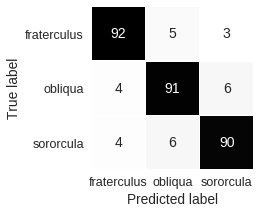

In [15]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


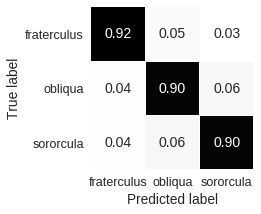

In [16]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


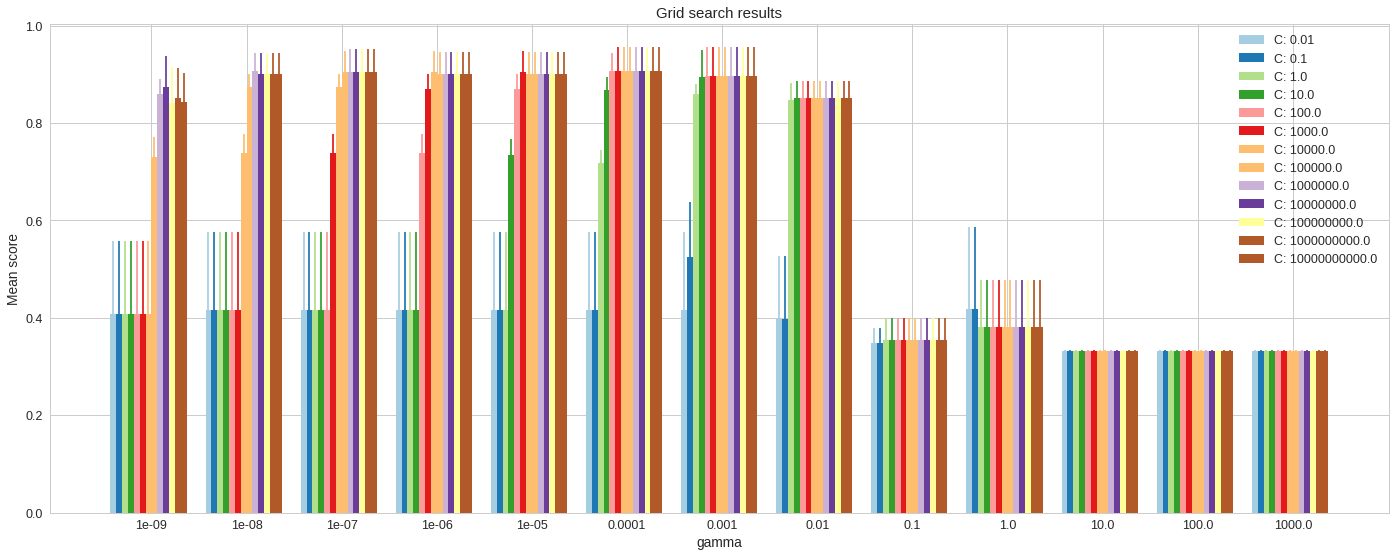

In [18]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(grid_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

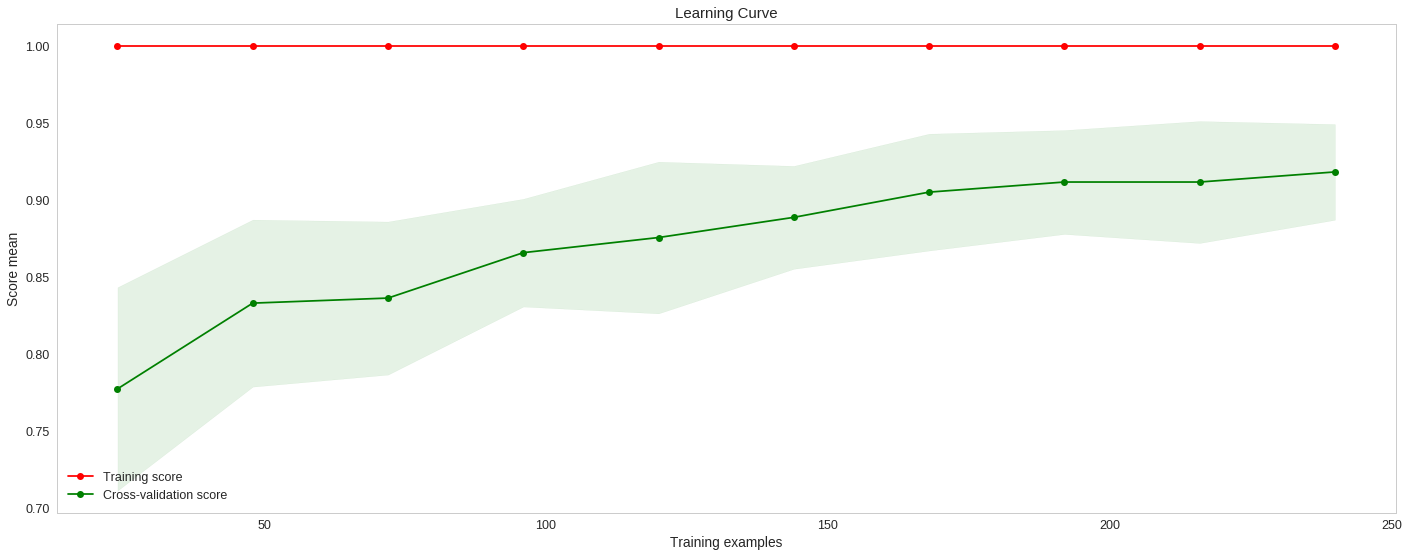

In [17]:
plt.style.use('seaborn-whitegrid')
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=grid_model.best_params_['C'],gamma=grid_model.best_params_['gamma'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()